# End to End ML project

This notebook contains a from-scratch sample project for housing price so we can explore on all the phases.

## Download the data
First, we need to obtain the data, let's write a function that obtains it from the web, decompress it and prepares the file for processing.

In [1]:
import os 
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Some notes on this data
We can see how many instances we have, this is a small dataset but good for training purposes.
Notice also for the attribute 'total_bedrooms' we are missing some data, we will need to deal with this later.

Also, notice ocean_proximity seems to be a categorical value, let's print the possible values

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's also explore the rest of the fields

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's explore the histogram for each variable to observe how they behave, notice we will print an histogram for each attribute in the datasets. We will need to use the ```%matplotlib inline``` to show all the plots.

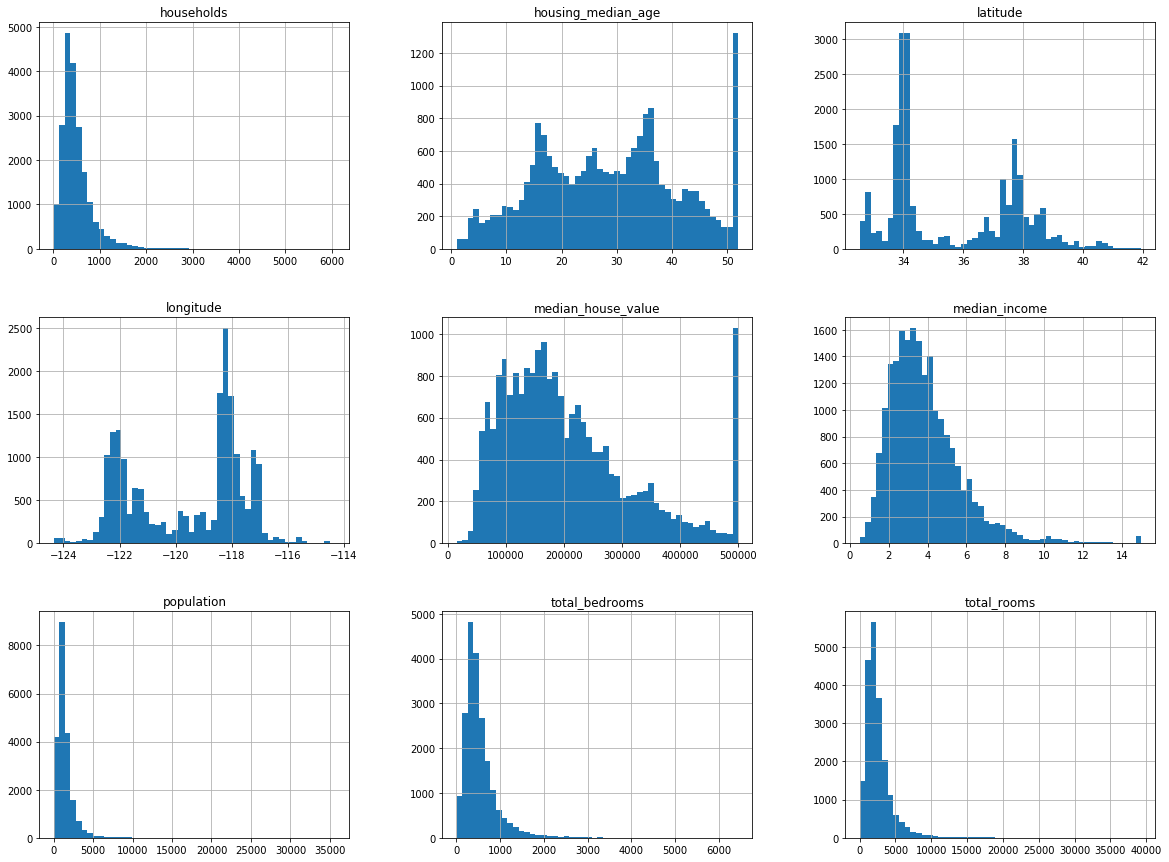

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

## Things to note about this dataset

* The median income seems to be in another scale and capped, notice the range of values, if we spot this details we must go to the source and check what is this data representation. According to the book, this value is scaled and capped at 15 for higher median incomes and at 05 for lower median incomes. This might no be a problem.
* Also notice there is a similar situation with housing median age and value, you can notice it by the spike on the highest value and seems very usual. According to the book, these values were also capped to 500000 for the higher values, however since the output of the model should be this value, this indeed might be a problem. According to the book, if we need to predict exact prices beyond 500000, we can:
    * Collect proper labels for the capped instances
    * Remove these instances all togheter.
* Notice also, some dimensions 

### Split dataset
It is important to split the dataset into training and test set, we should do this at random and forget about the test set while training the model to avoid data snooping bias. i.e., to gear the model to achieve better results at the test set only and creating a non-robust model

In [8]:
import numpy as np

def split_train_set(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [9]:
train_set, test_set = split_train_set(housing, 0.2)

In [10]:
print("{} train + {} test = {} total".format(len(train_set), len(test_set), len(housing)))

16512 train + 4128 test = 20640 total


Split sugin built-in functions in scikit-learn

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print("{} train + {} test = {} total".format(len(train_set), len(test_set), len(housing)))

16512 train + 4128 test = 20640 total


Let's create bins for the median income since we are told this is an important attribute for predicting housing price and we would want to do stratified sampling on this field so we can have a representative sample of different incomes.

For this, since the median income is a continuous value (number) we should categorize it, i.e., define stratum and get enough samples (strata) for each categories to make a representative sample.

In [12]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [14]:
housing["income_cat"].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

Let's group all the categories beyond 5 to 5 

In [15]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [16]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

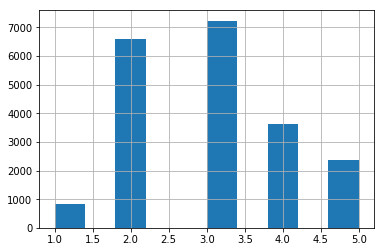

In [17]:
housing["income_cat"].hist()
plt.show()

Now we can do stratified sampling

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#strat_train_set = None
#strat_test_set = None

for train_index, test_index in split.split(housing, housing["income_cat"]):
    #df.loc works on named indexes while df.iloc works on numbered indexes
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now let's measure the proportions on the full dataset

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Notice we are preserving the same proportion in the test set in correspondance with the full set

Let's compare against overall and random all togheter

In [21]:
# Define the comparison function
def income_cat_proportion(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({ 
    "Overall":income_cat_proportion(housing),
    "Stratified":income_cat_proportion(strat_test_set),
    "Random":income_cat_proportion(test_set),
}).sort_index()
compare_props["Rand %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand %error,Strat %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


# ----> Verify the %error

Now we can remove the income_cat attribute and get the dataset in it's original state

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [23]:
# copy the obtained train set to play around with it without fear of damaging it
housing_training = strat_train_set.copy()

## Visualizing geographical data

First just draw a scatter plot with all datapoints, the data is just latitude and longitude hence applies to x, and y coordinates

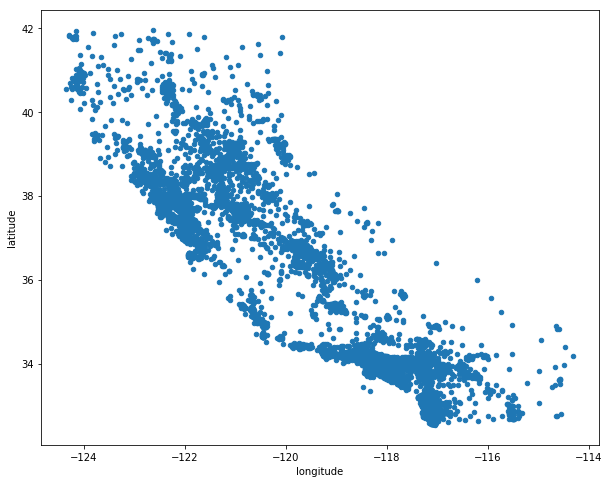

In [24]:
housing_training.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 8))
plt.show()

Let's change the alpha attribute to improve what we are seeing. The effect would be such that every point color is dimmed to 0.1, so when we see stronger colors, it means there is a high concentration of points in that zone. This give us a sense of density.

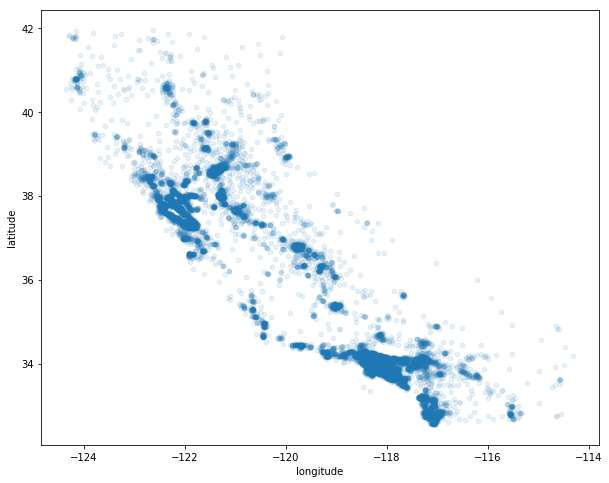

In [25]:
housing_training.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 8))
plt.show()

Now, let's add more dimensions to better plot the data, we will use the radius of each circle (option ```s```) to represent the population, then the color (option ```c```) to represent the price, the representation will be from the cmap called ```jet``` which ranges from blue (low values) to red (high values)

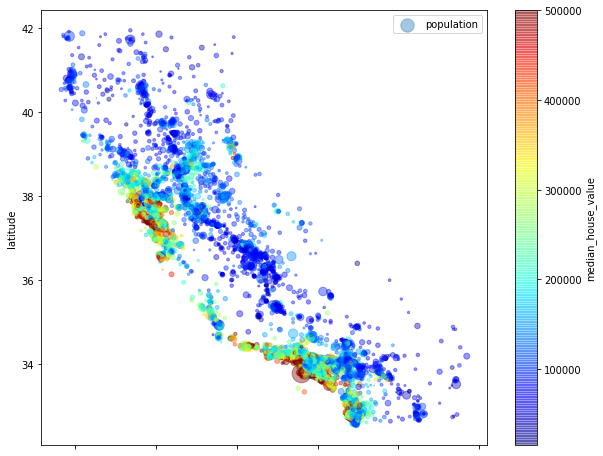

In [26]:
housing_training.plot(kind="scatter", x="longitude", y="latitude", 
                      alpha=0.4, 
                      s=housing["population"]/100, label="population",
                      c="median_house_value", cmap=plt.get_cmap("jet"),
                      colorbar=True,
                      figsize=(10, 8))
plt.legend()
plt.show()

Notice how nice we can observe several attributes with different representations, we can appreciate not only the high density zones but also to have an idea of the population and the price of housing.

## Correlation Matrix
Now, we can get the correlation matrix, with Pearson's r, comparing every field with every field to learn which fields are more correlated with others.

In [27]:
corr_matrix = housing_training.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


We are interested in the median house value, so it's natural to be interested in the variables with high correlation, either positive or negative, with the median house value, these might be suitable to use as model attributes

In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Notice we have a positive linear correlation with the median income, total rooms and housing median age, as well as a negative linear correlation with the latitude, the last one suggesting that the price goes down while we move to the north (up).

We can also do a scatter plot with these all these attributes but since the possible combinations are so many, we are only going to select the ones where we see certin level of correlation.

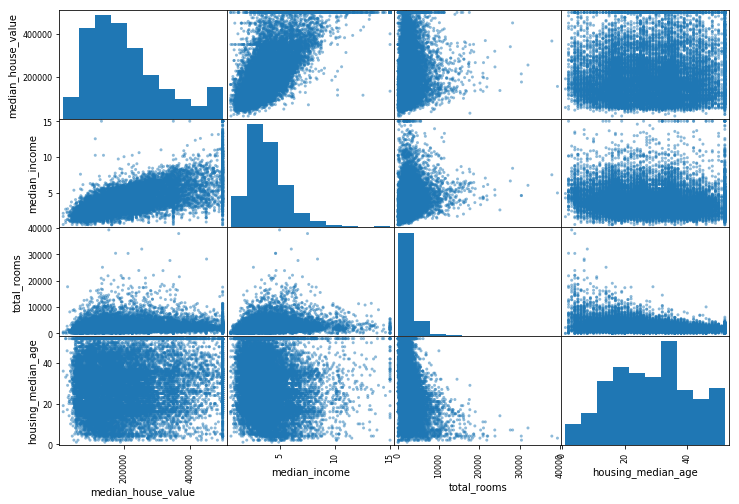

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing_training[attributes], figsize=(12, 8))
plt.show()

The most promising attribute would be the median income, hence let's zoom in

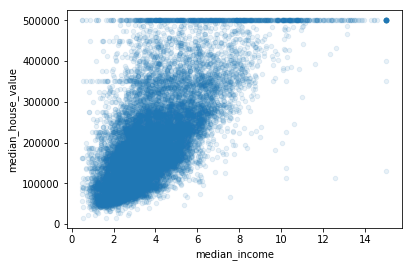

In [30]:
housing_training.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

Notice here the correlation seems pretty strong, and we can clearly see the 500,000 cap as a straight line in the top of the plot, we can also see other possible straight lines around 450 and 350, possible around 280 too. This is interesting and would be better to get rid of them to avoid the ML algorithm to learn from to repdoduce these data quirks.

### Experimenting with additional attributes
We can observe we have some interesting attributes like the total rooms, but this attribute alone is too general and not very usefull, we might want to know rooms per household. Similarly we might be interested in the number of bedrooms compared to the number of rooms. So we might be interested in calculating this data.

In [31]:
housing_training["rooms_per_household"] = housing_training["total_rooms"] / housing_training["households"]
housing_training["bedrooms_per_room"] = housing_training["total_bedrooms"] / housing_training["total_rooms"]
housing_training["population_per_household"] = housing_training["population"] / housing_training["households"]
housing_training.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,INLAND,5.140351,0.200683,2.540351
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,500001.0,<1H OCEAN,8.061372,0.141961,2.776173
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,INLAND,5.442667,0.143557,2.496000
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,<1H OCEAN,4.257991,0.249330,4.374429
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN,2.373272,0.444660,12.396313


Let's take a look at the correlation matrix again (for the housing_mean_value) to see how things changed

In [32]:
corr_matrix = housing_training.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Create transformation functions
It is a good practice to create transformation functions to more easily reproduce these steps when new data come in, when about to evaluate new data, to be used in the predictive pipeline, also these can be reused in any time.

In [33]:
# .drop() creates a copy of the df, so the original is not affected
housing_training = strat_train_set.drop("median_house_value", axis=1)
housing_training_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning
Most ML algorithms can't work with missing data, so let's fix this.

there is missing data for total bedrooms, we have 3 options here.

In [34]:
########### DO NOT RUN THIS ################
# get rid of the correspondign districts
#housing_training.dropna(subset=["total_bedrooms"])
# get rid of the whole attribute
#housing_training.drop("total_bedrooms", axis=1)
# Set values to some value (zero, the mean, median, etc.)
#median = housing_training["total_bedrooms"].median()
#housing_training["total_bedrooms"].fillna(median, inplace=True)

A more elaborated option 3 would be to use an Imputer to set the default value in case of missing ones.

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [36]:
housing_num = housing_training.drop("ocean_proximity", axis=1)


In [37]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [38]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [39]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
X = imputer.transform(housing_num)

In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In the previous example, we excluded the ocean proximity attribute as the imputer only works, as well as most ML algorithms, with numbers, hence, let's convert this into numbers too.

In [42]:
housing_cat = housing_training["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [43]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [44]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories="auto")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_encoded.shape

(16512,)

In [46]:
# -1 in reshape means inferred by the lenght of the array and remaining dimensions
housing_cat_encoded.reshape(-1, 1).shape

(16512, 1)

We can also do the from text categories to integer categories, then from integer categories to one-hot vectors in a single shot using the OneHotEncoder too.

#### Warning !!!
The book suggests to use ```CategoricalEncoder``` as a feature to add in sklearn 0.20.0, but this was dropped and the same functionality is being achieved by OneHotEncoder and OrdinalEncoder

In [47]:
cat_encoder = OneHotEncoder(sparse=True) # We can specify if we want a sparse or dense matrix here
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Implement a custom transformer
Now, following scikit-learn style of programming, we can create our own transformer with the same rules, i.e., implementing ```fit```, ```transform``` and ```fit_transform``` and make this suitable for a sklearn pipeline and so on.

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

# BaseEstimator adds the methods, get_params and set_params
# TransformerMixin adds the fit_transform method
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # To use BaseEstimator, we avoid using *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        # The same operation as above, rooms devided by households
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [50]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-122.23, 37.88, 41.0, ..., 5.0, 6.984126984126984,
        2.5555555555555554],
       [-122.22, 37.86, 21.0, ..., 5.0, 6.238137082601054,
        2.109841827768014],
       [-122.24, 37.85, 52.0, ..., 5.0, 8.288135593220339,
        2.8022598870056497],
       ...,
       [-121.22, 39.43, 17.0, ..., 2.0, 5.20554272517321,
        2.325635103926097],
       [-121.32, 39.43, 18.0, ..., 2.0, 5.329512893982808,
        2.1232091690544412],
       [-121.24, 39.37, 16.0, ..., 2.0, 5.254716981132075,
        2.616981132075472]], dtype=object)

In [51]:
housing.values[0]

array([-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 452600.0,
       'NEAR BAY', 5.0], dtype=object)

In [52]:
housing_extra_attribs[0]

array([-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 126.0, 8.3252, 452600.0,
       'NEAR BAY', 5.0, 6.984126984126984, 2.5555555555555554],
      dtype=object)

## Feature Scaling
Generally, ML algotihms don't perform well on features with very different scales, e.g., the range of number of rooms goes from 6 to 39320 and the median income range from 0 to 15. This is not that necessary in the target values (y).

### Min-max scaling (Normalization)
Obtained with $x` = \frac{x - min(x)}{max(x) - min(x)}$, it's very good wen whe want the values within some range, e.g., 0-1, but also is very sensitive to outliers, a value too large or too small compared with the rest, might drag the obtained value significanlty.

Scikit-Learn provides a transformer called ```MinMaxScaler``` for this.

### Standarization
Obtained with $x` = \frac{x - \overline{x}}{\sigma}$, i.e., substracting the mean, then dividing by the variance. It doesn;t need a range and is not sentitive to outliers but since it tends to yield values with unit distribution; it is not suitable for neural networks as these expects values ranging from 0 to 1.

Scikit-Learn provides a transormer called ```StandardScaler``` for this.

## Transformation Pipelines
Now, we can mix in all togheter into a pipeline and make this process more automated and reproducible, making easier to play around with the hyperparameters and so on.

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

### More custom transformers
By default, scikit-learn does not support pandas dataframe as input source, but we can creare our own transformer that accepts it and do the rest and finally plug it into the pipeline if we want.

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [67]:
# take the list of numeric attributes
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

We have two separate pipelines, we need to combine them togheter. Scikit-Learn offers ```FeatureUnion``` for this purpose.

In [69]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing_training)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [70]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model
Now with all the preparation in place, we will be able to easily feed the prepared data to different models and evaluate the results.

First, let's train a Linear Regression model.

In [71]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_training_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [72]:
lin_reg.coef_

array([-55650.4116403 , -56716.45236929,  13732.83841856,  -1933.1277138 ,
         7330.04062103, -45708.26306673,  45455.47519691,  74714.39134154,
         6605.12802802,   1042.95709453,   9249.75886697, -18016.52432168,
       -55219.15208555, 110357.78363967, -22479.84008184, -14642.2671506 ])

We did it!, let's try it on some data 

In [73]:
some_data = housing_training.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [74]:
some_labels = housing_training_labels.iloc[:5]
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [84]:
some_data_prepared = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)
print("Predictions: ", predictions)

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [86]:
print("Actual: ", some_labels.values)

Actual:  [286600. 340600. 196900.  46300. 254500.]


It works, though it seems there is some difference between the actual and predicted value, let's calculate the RMSE to see how well our model is performing in general.

In [88]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_training_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923